[[0.13587602 0.10189391 0.08035153 ... 0.22452652 0.20464393 0.23694877]
 [0.1052135  0.07704941 0.07207003 ... 0.27339437 0.21954714 0.25269061]
 [0.08284995 0.10603466 0.08450975 ... 0.25765253 0.27339437 0.28085471]
 ...
 [0.0248445  0.04970648 0.04058634 ... 0.04556573 0.05302607 0.05466839]
 [0.03892655 0.03810539 0.0248445  ... 0.04556573 0.03976518 0.03230484]
 [0.03562443 0.04722552 0.03728423 ... 0.033126   0.04638689 0.05632819]]


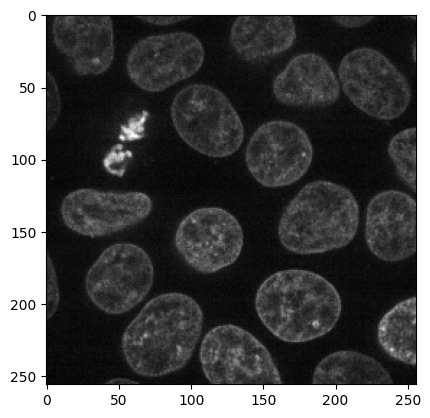

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import cells3d
from skimage.measure import label
from ipywidgets import interact, FloatSlider # <-- Changed from IntSlider
from matplotlib.colors import ListedColormap

# --- New import for normalization ---
from skimage.exposure import rescale_intensity

# --- 1. Load and Prepare Data ---
# Load the original 16-bit data
# --- Normalize the image to a 0.0 - 1.0 range ---
image_data_16bit = cells3d()[30, 1]
image_cells = rescale_intensity(image_data_16bit, out_range=(0.0, 1.0))

print(image_cells)


plt.imshow(image_cells, cmap='gray')

# Threshold Segmentation

In [10]:
# Find a good default threshold value (it will now be a float)
default_thresh = 0.3

# --- 2. Create the interactive function ---
# --- Use FloatSlider for the 0-1 range ---
@interact(threshold=FloatSlider(
    min=0.0,
    max=1.0,
    step=0.01,  # Use a small step for the float range
    value=default_thresh,
    description='Threshold:'
))
def interactive_threshold(threshold):
    # 1. Apply the user-selected threshold
    binary_mask = image_cells > threshold

    # 2. Count the number of separate objects found
    labeled_mask, num_objects = label(binary_mask, connectivity=1, return_num=True)

    # --- 3. Create a TRULY Random Colormap ---
    colors = [[0, 0, 0]] # Black background (label 0)
    for _ in range(num_objects):
        colors.append(np.random.rand(3)) # Add a random (R,G,B) color
    random_cmap = ListedColormap(colors)

    # --- 4. Plotting ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Original Image
    axs[0].imshow(image_cells, cmap='gray')
    axs[0].set_title('Original Image (Normalized 0-1)')
    axs[0].axis('off')

    # Plot 2: Histogram with threshold line
    # --- Update histogram range to 0-1 ---
    axs[1].hist(image_cells.ravel(), bins=100, range=(0.0, 1.0))
    axs[1].axvline(threshold, color='r', linestyle='--')
    axs[1].set_title('Histogram')
    axs[1].set_xlabel('Pixel Intensity (Normalized)')
    axs[1].set_ylabel('Pixel Count')

    # Plot 3: Resulting Labeled Mask (with random colors)
    axs[2].imshow(labeled_mask, cmap=random_cmap)
    axs[2].set_title(f'Result: Found {num_objects} Object(s)')
    axs[2].axis('off')

    plt.show()

interactive(children=(FloatSlider(value=0.3, description='Threshold:', max=1.0, step=0.01), Output()), _dom_cl…

# Threshold + Watershed

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import cells3d
from skimage.measure import label
from ipywidgets import interact, FloatSlider # <-- Changed to FloatSlider
from skimage.filters import threshold_otsu

# --- New Imports for Watershed ---
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from matplotlib.colors import ListedColormap # Import for custom colormap

# --- New import for normalization ---
from skimage.exposure import rescale_intensity

# --- 1. Load and Prepare Data ---
# Load the original 16-bit data
image_data_16bit = cells3d()[30, 1]

# --- Normalize the image to a 0.0 - 1.0 range ---
image_cells = rescale_intensity(image_data_16bit, out_range=(0.0, 1.0))

# Find a good default threshold value (it will now be a float)
default_thresh = threshold_otsu(image_cells)

# --- 2. Create the interactive function ---
# --- Use FloatSlider for the 0-1 range ---
@interact(threshold=FloatSlider(
    min=0.0,
    max=1.0,
    step=0.01,  # Use a small step for the float range
    value=default_thresh,
    description='Threshold:'
))
def interactive_segmentation(threshold):
    # 1. Apply the user-selected threshold
    binary_mask = image_cells > threshold

    # 2. Calculate the distance transform
    distance = distance_transform_edt(binary_mask)

    # 3. Find "seeds" for watershed
    coords = peak_local_max(distance, min_distance=7, labels=binary_mask, exclude_border=False)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True

    # Label the seeds
    markers, num_objects = label(mask, return_num=True)

    # 4. Apply the Watershed algorithm
    labeled_mask = watershed(-distance, markers, mask=binary_mask)

    # --- Generate TRULY Random Colormap ---
    # Start with a black color for the background (label 0)
    colors = [[0, 0, 0]] # Black

    # Add a new random (R, G, B) color for each object found
    for _ in range(num_objects):
        colors.append(np.random.rand(3))

    # Create the colormap from our list of colors
    random_cmap = ListedColormap(colors)

    # --- Plotting ---
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))

    # Plot 1: Original Image
    axs[0].imshow(image_cells, cmap='gray')
    axs[0].set_title('Original Image (Normalized 0-1)')
    axs[0].axis('off')

    # Plot 2: Histogram with threshold line
    # --- Update histogram range to 0-1 ---
    axs[1].hist(image_cells.ravel(), bins=100, range=(0.0, 1.0))
    axs[1].axvline(threshold, color='r', linestyle='--')
    axs[1].set_title('Histogram')
    axs[1].set_xlabel('Pixel Intensity (Normalized)')
    axs[1].set_ylabel('Pixel Count')

    # Plot 3: Simple Threshold Mask (The "Problem")
    axs[2].imshow(binary_mask, cmap='gray')
    axs[2].set_title('Threshold Mask (Merged Objects)')
    axs[2].axis('off')

    # Plot 4: Watershed Result (The "Solution")
    # Use the custom random_cmap here
    axs[3].imshow(labeled_mask, cmap=random_cmap)
    axs[3].set_title(f'Watershed Result: {num_objects} Object(s)')
    axs[3].axis('off')

    plt.show()

interactive(children=(FloatSlider(value=0.162109375, description='Threshold:', max=1.0, step=0.01), Output()),…

# Cellpose

In [1]:
# Install first time
!pip install cellpose

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from cellpose.models import CellposeModel
from skimage.segmentation import clear_border
from skimage.data import cells3d
from ipywidgets import interact, IntSlider, FloatSlider # <-- Import FloatSlider
from matplotlib.colors import ListedColormap

# --- 1. Get and prepare the image ---
image_to_segment = cells3d()[30, 1]
image_to_segment_scaled = (image_to_segment / image_to_segment.max() * 255).astype(np.uint8)

# --- 2. Load the Cellpose model ---
print("Loading Cellpose 'nuclei' model...")
model = CellposeModel(model_type='nuclei')
print("Model loaded. Interactive sliders are ready.")

# --- 3. Create the interactive function ---
@interact(
    diameter=IntSlider(
        min=10,
        max=100,
        step=1,
        value=30, # The default from your script
        description='Diameter:'
    ),
    # --- Add the new slider for flow_threshold ---
    flow_thresh=FloatSlider(
        min=0.0,
        max=1.0,
        step=0.1,
        value=0.4, # Cellpose's default
        description='Prob/Flow Thresh:'
    )
)
def interactive_cellpose(diameter, flow_thresh):
    print(f"Running segmentation with diameter={diameter}, flow_thresh={flow_thresh}...")

    # --- 3a. Run Cellpose ---
    masks, flows, styles = model.eval(
        image_to_segment_scaled,
        diameter=diameter,
        cellprob_threshold=flow_thresh # <-- Pass the new parameter
    )

    # --- 3b. Clean up the mask ---
    masks_cleaned = clear_border(masks)
    count = masks_cleaned.max()
    print(f"Found {count} nuclei.")

    # --- 3c. Create Random Colormap ---
    colors = [[0, 0, 0]] # Black background
    for _ in range(count):
        colors.append(np.random.rand(3)) # Add a random (R,G,B)
    random_cmap = ListedColormap(colors)

    # --- 4. Plot the results ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Display the prepared input image
    axs[0].imshow(image_to_segment_scaled, cmap='gray')
    axs[0].set_title("1. Prepared Input Image")
    axs[0].axis('off')

    # Display the Cellpose result
    axs[1].imshow(masks_cleaned, cmap=random_cmap)
    title = f"2. Cellpose Result: {count} nuclei\n(diam={diameter}, thresh={flow_thresh})"
    axs[1].set_title(title)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

Loading Cellpose 'nuclei' model...
Model loaded. Interactive sliders are ready.


interactive(children=(IntSlider(value=30, description='Diameter:', min=10), FloatSlider(value=0.4, description…

# StarDist

In [1]:
pip install "numpy<2.0"

In [2]:
!pip install stardist --no-cache-dir

# Cells3D

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from stardist.models import StarDist2D
from skimage.data import cells3d
from csbdeep.utils import normalize
from stardist.plot import render_label # Not used for random cmap, but good to know
from ipywidgets import interact, FloatSlider # <-- Import for sliders
from matplotlib.colors import ListedColormap # <-- Import for random colors

# --- 1. Load and Prepare the Image ---
print("Loading skimage.data.cells3d()...")
img = cells3d()[30, 1]

print("Normalizing image...")
# StarDist's 'normalize' is a percentile-based normalization
img_norm = normalize(img, 1, 99.8)

# --- 2. Load the StarDist Model ---
# This is slow, so we do it ONCE outside the function
print("Loading StarDist '2D_versatile_fluo' model...")
model = StarDist2D.from_pretrained('2D_versatile_fluo')
print("Model loaded. Interactive sliders are ready.")


# --- 3. Create the interactive function ---
@interact(
    prob_thresh=FloatSlider(
        min=0.0,
        max=1.0,
        step=0.05,
        value=0.5, # A good starting default
        description='Prob Thresh:'
    ),
    nms_thresh=FloatSlider(
        min=0.0,
        max=1.0,
        step=0.05,
        value=0.3, # A good starting default
        description='NMS Thresh:'
    )
)
def interactive_stardist(prob_thresh, nms_thresh):

    print(f"Running prediction with prob_thresh={prob_thresh}, nms_thresh={nms_thresh}...")

    # --- 3a. Run StarDist Prediction ---
    labels, details = model.predict_instances(
        img_norm,
        prob_thresh=prob_thresh,
        nms_thresh=nms_thresh
    )

    count = len(np.unique(labels)) - 1 # -1 to exclude background (label 0)
    print(f"Prediction complete. Found {count} cells.")

    # --- 3b. Create Random Colormap ---
    colors = [[0, 0, 0]] # Black background
    for _ in range(count):
        colors.append(np.random.rand(3)) # Add a random (R,G,B)
    random_cmap = ListedColormap(colors)

    # --- 4. Plot the results ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(img_norm, cmap='gray')
    axs[0].set_title("1. Normalized Image")
    axs[0].axis('off')

    axs[1].imshow(labels, cmap=random_cmap)
    title = f"2. StarDist Result: {count} cells\n(prob={prob_thresh}, nms={nms_thresh})"
    axs[1].set_title(title)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

Loading skimage.data.cells3d()...
Normalizing image...
Loading StarDist '2D_versatile_fluo' model...
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Model loaded. Interactive sliders are ready.


interactive(children=(FloatSlider(value=0.5, description='Prob Thresh:', max=1.0, step=0.05), FloatSlider(valu…

In [ ]:
# --- 0. Make sure cellpose is installed ---
# !pip install cellpose

import matplotlib.pyplot as plt
import numpy as np
# This import (CellposeModel) was correct for your version
from skimage.segmentation import clear_border

from skimage.color import rgb2hed
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
from skimage.data import immunohistochemistry

image_ihc = immunohistochemistry()

ihc_hed = rgb2hed(image_ihc)

h_channel = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1))


image_to_segment = 1 - h_channel

# Cellpose models work best on 0-255 integer images
image_to_segment = (image_to_segment * 255).astype(np.uint8)

model = StarDist2D.from_pretrained('2D_versatile_fluo')

print("Running prediction...")
labels, details = model.predict_instances(image_to_segment, prob_thresh = .001)

print(f"Prediction complete. Found {len(np.unique(labels)) - 1} cells.")

# --- 4. Plot the successful result ---
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].imshow(image_to_segment, cmap='gray')
axs[0].set_title("1. Original Image")
axs[0].axis('off')

axs[1].imshow(labels, cmap='nipy_spectral')

plt.tight_layout()
plt.show()

NameError: name 'StarDist2D' is not defined

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Running prediction...


Prediction complete. Found 400 cells.


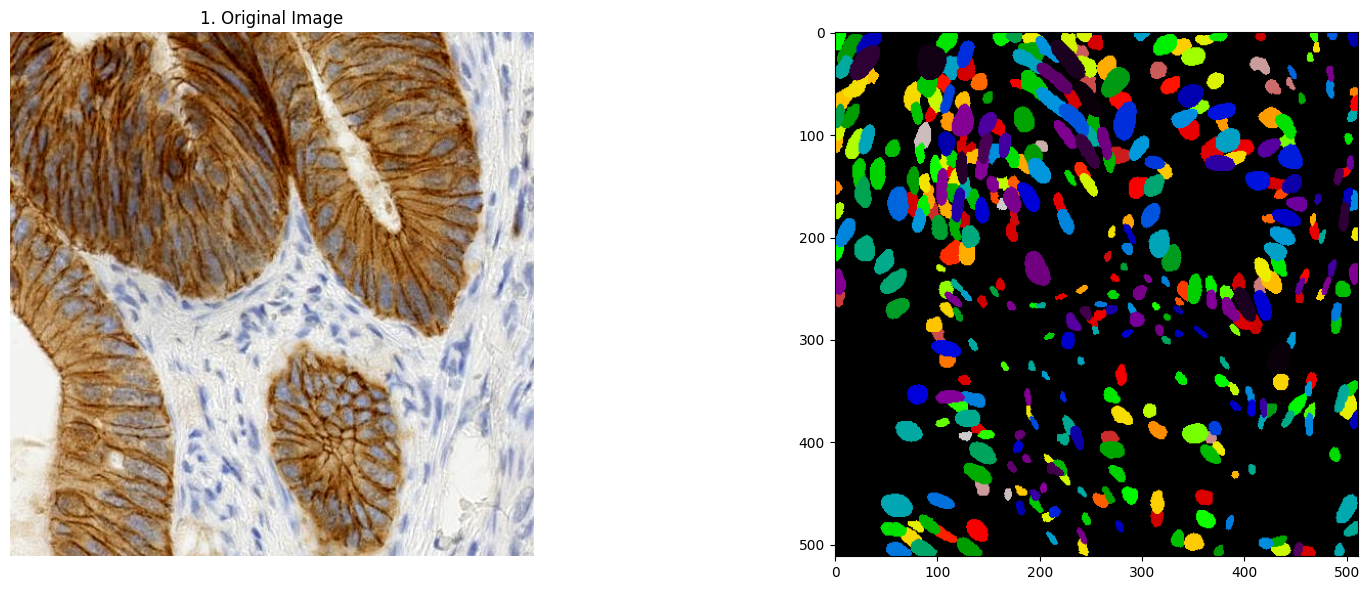

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from stardist.models import StarDist2D
from stardist.plot import render_label
from skimage.data import immunohistochemistry
# --- Import the normalize function ---
from csbdeep.utils import normalize

# --- 1. Load Image ---
image_ihc = immunohistochemistry() # This is uint8 (0-255)

# --- 2. Normalize the Image ---
# This converts the image to float and scales it
# based on the 1st and 99.8th percentiles.
img_norm = normalize(image_ihc, 1, 99.8)

# --- 3. Load Model ---
model = StarDist2D.from_pretrained('2D_versatile_he')

# --- 4. Run Prediction ---
print("Running prediction...")
# Pass the NORMALIZED float image to the model
labels, details = model.predict_instances(img_norm, prob_thresh = .001)

print(f"Prediction complete. Found {len(np.unique(labels)) - 1} cells.")

# --- 4. Plot the successful result ---
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].imshow(img_norm, cmap='gray')
axs[0].set_title("1. Original Image")
axs[0].axis('off')

axs[1].imshow(labels, cmap='nipy_spectral')

plt.tight_layout()
plt.show()

# Application

--- 1. Cell Counting ---
Total cells found: 427

Extracting DAB (brown) stain channel...
Measuring properties for all 427 nuclei...

--- 4. Data Table (Top 5 Cells) ---


,label,area,eccentricity,centroid-0,centroid-1,mean_intensity
0,1,6400.0,0.920669,358.557031,25.225000,0.988218
1,2,1312.0,0.733781,394.460366,393.926067,0.988912
2,3,5459.0,0.849154,433.970141,449.440191,0.994165
3,4,147.0,0.321396,315.129252,433.476190,0.996005
4,5,549.0,0.838676,50.262295,122.571949,0.924152



--- 5. Visualizing Distributions ---


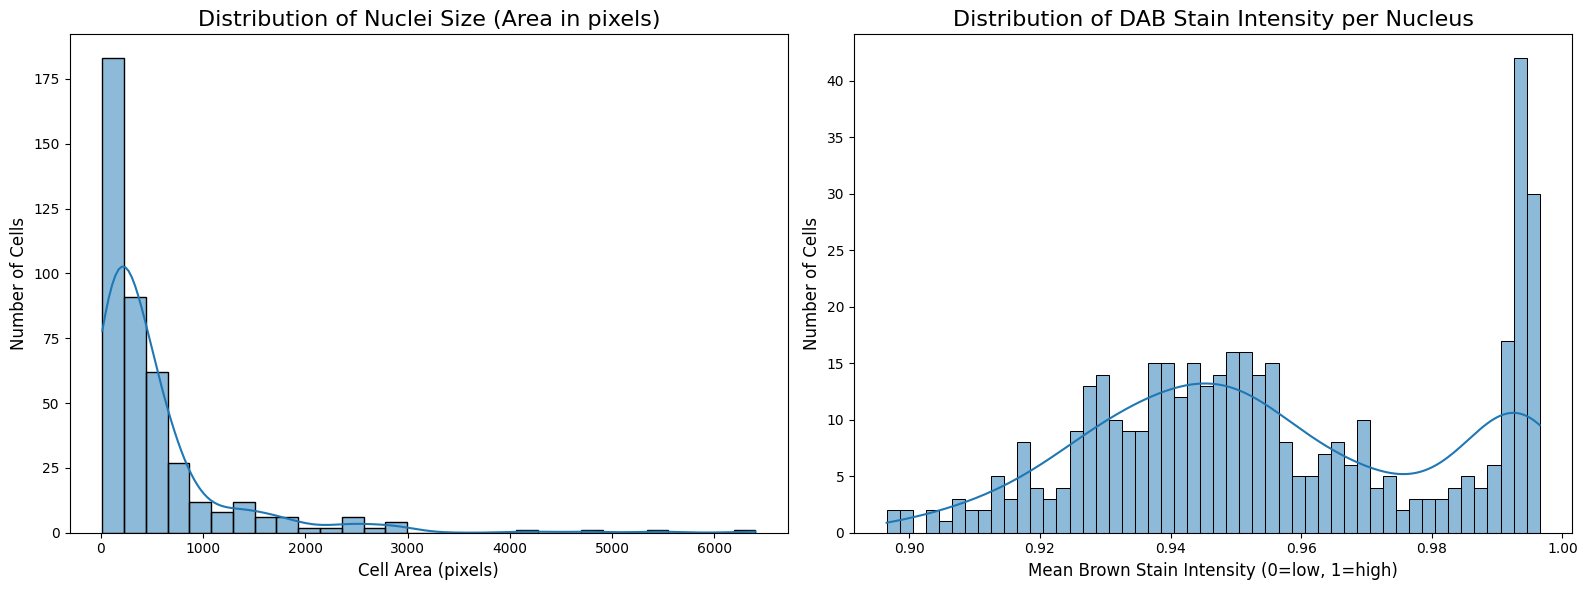


--- 6. Visualizing Spatial Data (Example) ---


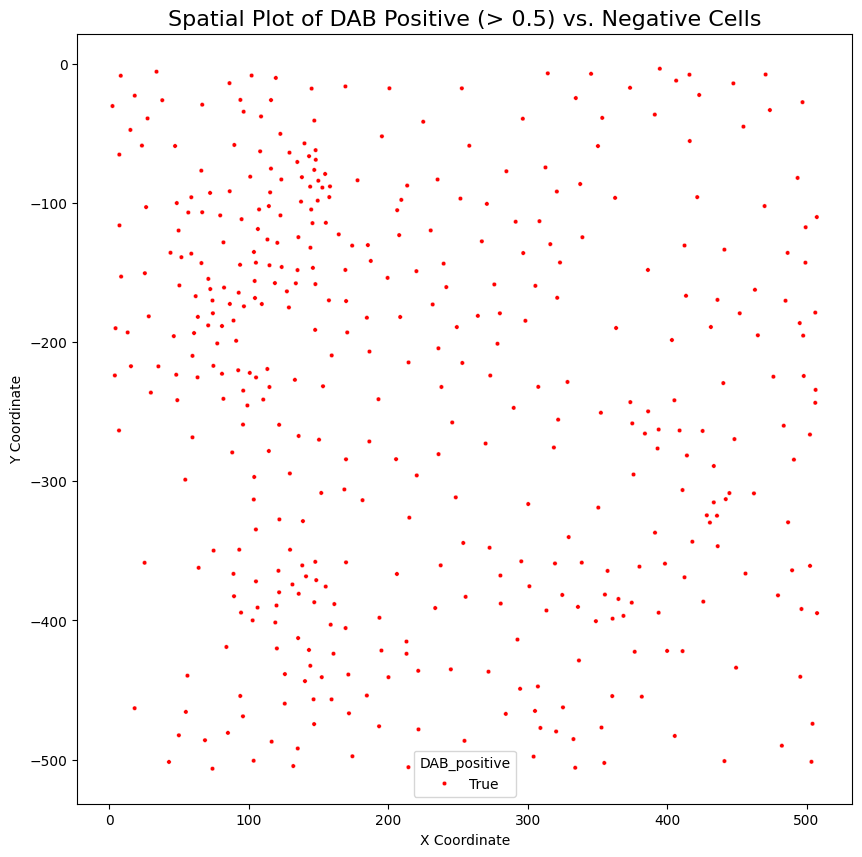

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import regionprops_table
from skimage.color import rgb2hed
from skimage.exposure import rescale_intensity

# --- 0. Check for necessary variables ---
# This code assumes 'image_ihc' (original color image) and
# 'labels' (the segmentation mask) exist from the previous cell.
try:
    _ = image_ihc
    _ = labels
except NameError:
    print("Error: 'image_ihc' or 'labels' not found.")
    print("Please re-run the StarDist/Cellpose segmentation block first.")
    # Stop execution if variables are missing
    raise

# --- 1. Cell Counting ---
cell_count = labels.max()
print(f"--- 1. Cell Counting ---")
print(f"Total cells found: {cell_count}")

# --- 2. Prepare Intensity Channel (DAB/Brown) ---
# We need to re-create the DAB channel to measure it.
print("\nExtracting DAB (brown) stain channel...")
ihc_hed = rgb2hed(image_ihc)
d_channel = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1))

# Invert the channel:
# DAB stain is dark (low value), so we invert it.
# Now, a high value = more brown stain.
intensity_image_dab = 1 - d_channel

# --- 3. Measure Morphometry & Intensity (The "Cookie Cutter" Step) ---
print(f"Measuring properties for all {cell_count} nuclei...")

properties_to_measure = [
    'label',            # The unique ID
    'area',             # Morphometry: Size
    'eccentricity',     # Morphometry: Shape (0=circle, 1=line)
    'centroid',         # Spatial: (x,y) coordinate
    'mean_intensity'    # Intensity: Avg. DAB signal
]

# This is the key function. It uses 'labels' as the "cookie cutter"
# on the 'intensity_image_dab' to measure properties for each nucleus.
props_dict = regionprops_table(
    label_image=labels,
    intensity_image=intensity_image_dab, # Use DAB channel
    properties=properties_to_measure
)

# Convert to a clean pandas DataFrame
props_df = pd.DataFrame(props_dict)

print("\n--- 4. Data Table (Top 5 Cells) ---")
display(props_df.head())

# --- 5. Visualize the Results ---
print("\n--- 5. Visualizing Distributions ---")
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Histogram of Cell Size (Morphometry)
sns.histplot(props_df['area'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Nuclei Size (Area in pixels)', fontsize=16)
axs[0].set_xlabel('Cell Area (pixels)', fontsize=12)
axs[0].set_ylabel('Number of Cells', fontsize=12)

# Plot 2: Histogram of DAB Intensity (Quantification)
sns.histplot(props_df['mean_intensity'], bins=50, kde=True, ax=axs[1])
axs[1].set_title('Distribution of DAB Stain Intensity per Nucleus', fontsize=16)
axs[1].set_xlabel('Mean Brown Stain Intensity (0=low, 1=high)', fontsize=12)
axs[1].set_ylabel('Number of Cells', fontsize=12)

plt.tight_layout()
plt.show()

print("\n--- 6. Visualizing Spatial Data (Example) ---")
# A simple scatter plot showing DAB-positive vs. negative cells
# We'll set a simple threshold on the intensity for visualization
dab_threshold = 0.5 # Adjust this threshold
props_df['DAB_positive'] = props_df['mean_intensity'] > dab_threshold

plt.figure(figsize=(10, 10))
# We need to flip the y-axis (row) for plotting
sns.scatterplot(
    data=props_df,
    x='centroid-1', # Centroid[1] is x
    y=props_df['centroid-0'] * -1, # Centroid[0] is y (row), invert it
    hue='DAB_positive',
    palette={True: 'red', False: 'blue'},
    s=10 # Small dot size
)
plt.title(f'Spatial Plot of DAB Positive (> {dab_threshold}) vs. Negative Cells', fontsize=16)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal')
plt.show()